In [2]:
import os
import numpy as np
import pandas as pd
from utils.utils import * 
from utils.kabsch2D import kabsch2D
from utils.get_betas_mod import get_betas_mod
from utils.split_condition import split_conditions
from nsddatapaper_rsa.utils.nsd_get_data import get_conditions, get_labels, get_betas
from nsddatapaper_rsa.utils.utils import category_dict
from matplotlib import cm 
import scprep

In [98]:
conds1 = np.load('/media/Working/stan-thesis/data/conditions/subj01/subj01.conditions.npy')
conds2 = np.load('/media/Working/stan-thesis/data/conditions/subj02/subj02.conditions.npy')
conds3 = np.load('/media/Working/stan-thesis/data/conditions/subj03/subj03.conditions.npy')
conds4 = np.load('/media/Working/stan-thesis/data/conditions/subj04/subj04.conditions.npy')
conds5 = np.load('/media/Working/stan-thesis/data/conditions/subj05/subj05.conditions.npy')
conds6 = np.load('/media/Working/stan-thesis/data/conditions/subj06/subj06.conditions.npy')
conds7 = np.load('/media/Working/stan-thesis/data/conditions/subj07/subj07.conditions.npy')
conds8 = np.load('/media/Working/stan-thesis/data/conditions/subj08/subj08.conditions.npy')

common_conditions = reduce(np.intersect1d, (conds1, conds2, conds3, conds4, conds5, conds6, conds7, conds8))
print(common_conditions.shape)


(907,)


In [103]:
mds_V01_s1 = np.load(os.path.join(mds_dir, 'subj01', 'subj01_VO-1_MDS_rotated_VO-1_train.npy'), allow_pickle=True)
mds_V01_s2 = np.load(os.path.join(mds_dir, 'subj02', 'subj02_VO-1_MDS_rotated_VO-1_train.npy'), allow_pickle=True)
mds_V01_s1.shape

(10000, 2)

In [106]:
mds_V01_s1_new = mds_V01_s1[np.isin(conds1, common_conditions)]
mds_V01_s1_new.shape

(907, 2)

In [25]:
models_subs = {}
models = ['wself' ,'oself']
columns = ["x0", "y0", "sigma", "slope", "intercept", "test_var_explained", "var_explained", "mds_ecc", "mds_ang", "roi", "fit_with"]
model_study = 'oself'
mode = "train"
rotated = False

for i, sub in enumerate(subj_list):
    models_subs[sub] = {}
    for m in models:
        if rotated:
            m_file = os.path.join(models_dir, f'best_fits_{m}_{sub}_{mode}_basevoxel_rotated.npy')
        if not rotated:
            m_file = os.path.join(models_dir, f'best_fits_{m}_{sub}_{mode}_basevoxel_notrotated.npy')
        models_subs[sub][m] = pd.DataFrame(np.load(m_file, allow_pickle=True), columns=columns)
        models_subs[sub][m][columns[:-2]] = models_subs[sub][m][columns[:-2]].astype(np.float32)

In [31]:
models_subs

{'subj01': {'wself':              x0        y0      sigma       slope   intercept  \
  0      0.822397 -0.278019   8.283981   37.893143  -37.587017   
  1      0.986727 -0.329719  10.249476   47.714718  -47.396034   
  2      1.050000 -0.367991  10.785832   48.691101  -48.372013   
  3      0.773744 -0.267398   8.746958   42.137474  -41.852310   
  4      0.705171 -0.219385   9.600308   52.214237  -51.949696   
  ...         ...       ...        ...         ...         ...   
  33792 -0.388130  1.050000   8.456862   93.248970  -92.868904   
  33793 -0.418914 -0.033295   7.147995   72.106918  -71.671936   
  33794 -0.591129  0.184483   8.424049   80.171410  -79.725021   
  33795 -0.443142 -0.142610   9.473189  133.685791 -133.204742   
  33796 -0.623854 -0.014593  10.512757  119.072441 -118.621010   
  
         test_var_explained  var_explained   mds_ecc   mds_ang roi fit_with  
  0                0.013588       0.085281  0.886032  1.896794  V1      hV4  
  1                0.013476   

In [32]:
import nibabel as nib
threshold = []
for sub in subj_list:
    maskdata_lh_path = os.path.join(mask_dir, sub , f'lh.{sub}.testrois.mgz')
    maskdata_lh = nib.load(maskdata_lh_path).get_fdata().squeeze()
    lh_indices = np.where((maskdata_lh >= 1) & (maskdata_lh <= 15))[0] 
    threshold.append(lh_indices.shape[0])

threshold

[17901, 19290, 17885, 13606, 14050, 19115, 13976, 15588]

In [33]:
variance = np.zeros((len(subj_list), len(rois.keys())))
m = models[1]
for i, sub in enumerate(subj_list):
    for j, roi in enumerate(rois.keys()):
        variance[i, j] = models_subs[sub][m].groupby('roi')['var_explained'].mean()[roi]

var_df = pd.DataFrame(variance, index=subj_list, columns=rois.keys())
#var_df.to_csv('variance_notrotated.csv', index=True)
var_df

,V1,V2,V3,hV4,VO-1,VO-2,PHC-1,PHC-2,LO-1,LO-2,TO-1,TO-2
subj01,0.076568,0.072132,0.073761,0.031702,0.031996,0.020741,0.025427,0.119857,0.027748,0.077066,0.172363,0.076257
subj02,0.131163,0.043484,0.064261,0.044195,0.050208,0.018919,0.041090,0.131469,0.080611,0.086181,0.155387,0.021992
subj03,0.183902,0.087432,0.148759,0.072290,0.064414,0.051803,0.056045,0.084759,0.078634,0.100573,0.121247,0.015881
subj04,0.130110,0.057405,0.073082,0.033514,0.031095,0.020273,0.073360,0.097488,0.042453,0.078766,0.086123,0.041021
subj05,0.094425,0.079574,0.088339,0.038496,0.062702,0.063047,0.131970,0.217765,0.087856,0.108180,0.090310,0.135124
subj06,0.057719,0.067797,0.066148,0.033274,0.039578,0.035676,0.047889,0.067885,0.040735,0.080558,0.139644,0.025947
subj07,0.093755,0.101591,0.131207,0.091995,0.064366,0.035860,0.044472,0.048143,0.159973,0.075664,0.033574,0.013939
subj08,0.068629,0.072972,0.086423,0.061116,0.027684,0.011644,0.026740,0.064618,0.065102,0.039225,0.019056,0.014221


In [34]:
test_variance = np.zeros((len(subj_list), len(rois.keys())))
m = models[1]
for i, sub in enumerate(subj_list):
    for j, roi in enumerate(rois.keys()):
        test_variance[i, j] = models_subs[sub][m].groupby('roi')['test_var_explained'].mean()[roi]

test_var_df = pd.DataFrame(test_variance, index=subj_list, columns=rois.keys())
#test_var_df.to_csv('test_variance_notrotated.csv', index=True)
test_var_df

,V1,V2,V3,hV4,VO-1,VO-2,PHC-1,PHC-2,LO-1,LO-2,TO-1,TO-2
subj01,0.020061,0.024599,0.028102,0.006704,0.006038,0.001205,-0.000504,0.045602,0.004255,0.019947,0.112967,0.031360
subj02,0.052120,0.013884,0.023750,0.000542,0.005357,-0.004125,0.001707,0.046504,0.028635,0.019667,0.077120,0.003169
subj03,-0.009582,-0.001906,-0.014460,-0.008087,0.005737,-0.007017,0.011596,0.033603,-0.011710,0.003969,0.070339,0.010125
subj04,0.023780,0.007202,0.004065,-0.007424,-0.009167,-0.018012,-0.013945,0.017712,0.000777,-0.004043,0.031522,0.005109
subj05,0.013025,0.010748,0.007668,-0.001056,0.002531,0.007741,0.045138,0.083541,0.004914,0.021058,0.041287,0.071646
subj06,0.012192,0.011738,0.005183,-0.004300,-0.000517,0.003039,-0.016918,0.010041,0.006544,0.033192,0.066874,0.005053
subj07,-0.001341,-0.010841,-0.014084,-0.022722,0.004575,-0.011937,-0.007484,-0.008730,-0.065581,0.007143,0.003994,-0.001561
subj08,0.002348,-0.002088,0.001091,-0.000202,-0.003080,-0.003358,0.001176,0.014636,-0.018498,0.011219,0.009713,-0.004543


In [28]:
models_subs = {}
models = ['wself' ,'oself']
columns = ["x0", "y0", "sigma", "slope", "intercept", "test_var_explained", "var_explained", "mds_ecc", "mds_ang", "roi", "fit_with"]
model_study = 'oself'
mode = "train"
rotated = True

for i, sub in enumerate(subj_list):
    models_subs[sub] = {}
    for m in models:
        if rotated:
            m_file = os.path.join(models_dir, f'best_fits_{m}_{sub}_{mode}_basevoxel_rotated.npy')
        if not rotated:
            m_file = os.path.join(models_dir, f'best_fits_{m}_{sub}_{mode}_basevoxel_notrotated.npy')
        models_subs[sub][m] = pd.DataFrame(np.load(m_file, allow_pickle=True), columns=columns)
        models_subs[sub][m][columns[:-2]] = models_subs[sub][m][columns[:-2]].astype(np.float32)

In [39]:
variance = np.zeros((len(subj_list), len(rois.keys())))
m = models[1]
for i, sub in enumerate(subj_list):
    for j, roi in enumerate(rois.keys()):
        variance[i, j] = models_subs[sub][m].groupby('roi')['var_explained'].mean()[roi]

var_df = pd.DataFrame(variance, index=subj_list, columns=rois.keys())
var_df.to_csv('variance_rotated.csv', index=True)
var_df

,V1,V2,V3,hV4,VO-1,VO-2,PHC-1,PHC-2,LO-1,LO-2,TO-1,TO-2
subj01,0.076568,0.072132,0.073761,0.031702,0.031996,0.020741,0.025427,0.119857,0.027748,0.077066,0.172363,0.076257
subj02,0.131163,0.043484,0.064261,0.044195,0.050208,0.018919,0.041090,0.131469,0.080611,0.086181,0.155387,0.021992
subj03,0.183902,0.087432,0.148759,0.072290,0.064414,0.051803,0.056045,0.084759,0.078634,0.100573,0.121247,0.015881
subj04,0.130110,0.057405,0.073082,0.033514,0.031095,0.020273,0.073360,0.097488,0.042453,0.078766,0.086123,0.041021
subj05,0.094425,0.079574,0.088339,0.038496,0.062702,0.063047,0.131970,0.217765,0.087856,0.108180,0.090310,0.135124
subj06,0.057719,0.067797,0.066148,0.033274,0.039578,0.035676,0.047889,0.067885,0.040735,0.080558,0.139644,0.025947
subj07,0.093755,0.101591,0.131207,0.091995,0.064366,0.035860,0.044472,0.048143,0.159973,0.075664,0.033574,0.013939
subj08,0.068629,0.072972,0.086423,0.061116,0.027684,0.011644,0.026740,0.064618,0.065102,0.039225,0.019056,0.014221


In [38]:
test_variance = np.zeros((len(subj_list), len(rois.keys())))
m = models[1]
for i, sub in enumerate(subj_list):
    for j, roi in enumerate(rois.keys()):
        test_variance[i, j] = models_subs[sub][m].groupby('roi')['test_var_explained'].mean()[roi]

test_var_df = pd.DataFrame(test_variance, index=subj_list, columns=rois.keys())
test_var_df.to_csv('test_variance_rotated.csv', index=True)
test_var_df

,V1,V2,V3,hV4,VO-1,VO-2,PHC-1,PHC-2,LO-1,LO-2,TO-1,TO-2
subj01,0.020061,0.024599,0.028102,0.006704,0.006038,0.001205,-0.000504,0.045602,0.004255,0.019947,0.112967,0.031360
subj02,0.052120,0.013884,0.023750,0.000542,0.005357,-0.004125,0.001707,0.046504,0.028635,0.019667,0.077120,0.003169
subj03,-0.009582,-0.001906,-0.014460,-0.008087,0.005737,-0.007017,0.011596,0.033603,-0.011710,0.003969,0.070339,0.010125
subj04,0.023780,0.007202,0.004065,-0.007424,-0.009167,-0.018012,-0.013945,0.017712,0.000777,-0.004043,0.031522,0.005109
subj05,0.013025,0.010748,0.007668,-0.001056,0.002531,0.007741,0.045138,0.083541,0.004914,0.021058,0.041287,0.071646
subj06,0.012192,0.011738,0.005183,-0.004300,-0.000517,0.003039,-0.016918,0.010041,0.006544,0.033192,0.066874,0.005053
subj07,-0.001341,-0.010841,-0.014084,-0.022722,0.004575,-0.011937,-0.007484,-0.008730,-0.065581,0.007143,0.003994,-0.001561
subj08,0.002348,-0.002088,0.001091,-0.000202,-0.003080,-0.003358,0.001176,0.014636,-0.018498,0.011219,0.009713,-0.004543


In [5]:
mds_V1_path = os.path.join(mds_dir, 'subj01', 'subj01_V1_mds_train.npy')
mds_V1 = np.load(mds_V1_path)
mds_V1

array([[ 0.17524675,  0.6280198 ],
       [ 0.1813852 , -0.72059274],
       [ 0.7874401 ,  0.1343851 ],
       ...,
       [-0.45145717,  0.62289834],
       [-0.3352772 , -0.13621671],
       [-0.76683396,  0.15989353]], dtype=float32)

In [6]:
conditions1 = get_conditions(nsd_dir, 'subj01', 40)
conditions1 = np.asarray(conditions1).ravel()

labels_path = os.path.join(data_dir, 'all_stims_category_labels.npy')
labels = np.load(labels_path, allow_pickle=True)

		sub: subj01 fetching condition trials in session: 1
		sub: subj01 fetching condition trials in session: 2
		sub: subj01 fetching condition trials in session: 3
		sub: subj01 fetching condition trials in session: 4
		sub: subj01 fetching condition trials in session: 5
		sub: subj01 fetching condition trials in session: 6
		sub: subj01 fetching condition trials in session: 7
		sub: subj01 fetching condition trials in session: 8
		sub: subj01 fetching condition trials in session: 9
		sub: subj01 fetching condition trials in session: 10
		sub: subj01 fetching condition trials in session: 11
		sub: subj01 fetching condition trials in session: 12
		sub: subj01 fetching condition trials in session: 13
		sub: subj01 fetching condition trials in session: 14
		sub: subj01 fetching condition trials in session: 15
		sub: subj01 fetching condition trials in session: 16
		sub: subj01 fetching condition trials in session: 17
		sub: subj01 fetching condition trials in session: 18
		sub: subj01 fetch

In [7]:
category_colors = cm.RdYlBu(range(80))

sample, sample_idx = np.unique(conditions1, return_index=True)
categories_sampled = labels[sample_idx]

category_matrix = get_labels(sub, betas_dir, nsd_dir,  sample, labels, categories_sampled)
category_matrix.shape

computing category labels
saving serialised label matrix to:
	 /media/Working/stan-thesis/projects/betas/subj05_sample_labels.npy


(10000, 80)

In [8]:
category_matrix

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]])

In [14]:
# also prepare the category binary maps


flat_labels = [item for sublist in labels for item in sublist]
all_labels = sorted(list(set(flat_labels)))

category_classes = []
for cat_i in range(80):
    flat = np.full(len(sample), '0_unknown')
    flat[category_matrix[:, cat_i] == 1] = all_labels[cat_i]
    category_classes.append(flat)

# prepare the class labels
class_labels = []
schism = []
class_schism = []
i = 0
for categ_v in category_matrix:

    # 1 is animate, 0 inanimate
    cat_is = np.where(categ_v)[0]
    anim_class = [category_dict[str(x)] for x in cat_is]

    n_anim = np.sum(anim_class)

    # special case only people
    if len(cat_is) == 1 and cat_is == 49:
        class_label = 'a_people'

    # people with other animates
    elif 49 in cat_is and n_anim == len(anim_class):
        class_label = 'a_people_animates'

    # people with inanimates
    elif 49 in cat_is and n_anim == 1:
        class_label = 'a_people_inanimates'
        schism.append(i)
        class_schism.append(class_label)

    # people with both animates and inanimates
    elif 49 in cat_is and n_anim < len(anim_class):
        class_label = 'a_people_animates_inanimates'

    # all ones? only animate
    elif n_anim == len(anim_class):
        class_label = 'animates'

    elif np.sum(anim_class) == 0:  # only inanimate
        class_label = 'inanimates'
        schism.append(i)
        class_schism.append(class_label)

    # mixed non-people and inanimates
    else:
        class_label = 'animates_inanimates'

    class_labels.append(class_label)
    i += 1

n_images = len(sample)
all_conditions = range(n_images)

In [19]:
mds_V1_path = os.path.join(mds_dir, 'subj01', 'subj01_V1_mds_train.npy')
mds_V1 = np.load(mds_V1_path)
mds_V1R_path = os.path.join(mds_dir, 'subj01', 'subj01_V1_MDS_rotated_VO-1_train.npy')
mds_V1R = np.load(mds_V1R_path)
mds_V1R

array([[ 0.01960987, -0.65171754],
       [-0.38763225,  0.6339524 ],
       [-0.7117589 , -0.3626576 ],
       ...,
       [ 0.6163889 , -0.4603049 ],
       [ 0.27954167,  0.22983086],
       [ 0.77967143,  0.07558198]], dtype=float32)

/home/harveylab/miniconda3/envs/thesis/lib/python3.10/site-packages/scprep/plot/utils.py:104: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


<Axes: xlabel='MDS1', ylabel='MDS2'>

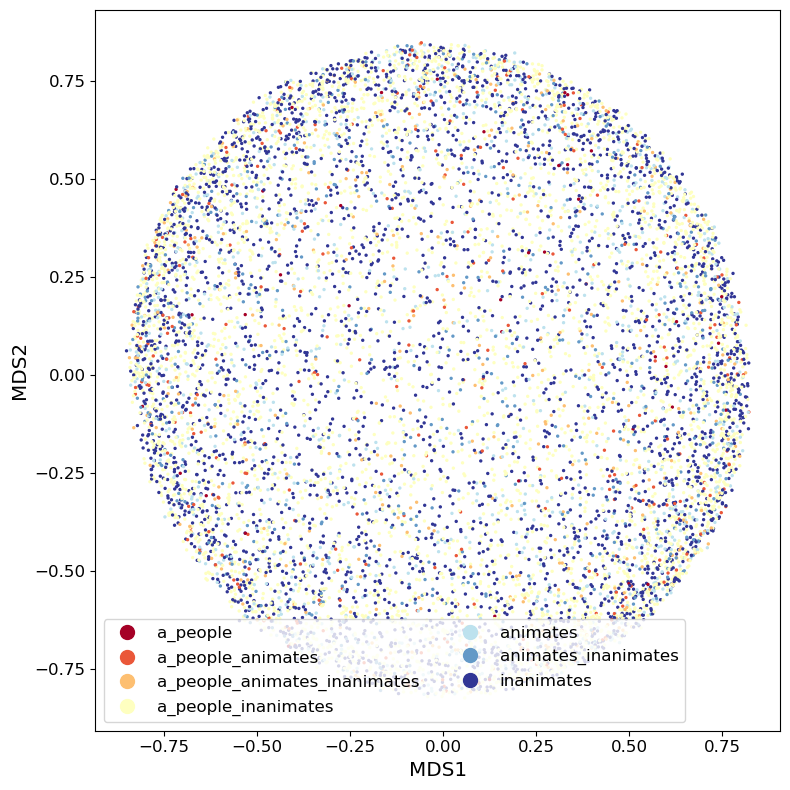

In [18]:
scprep.plot.scatter2d(
        mds_V1,
        c=class_labels,
        figsize=(8, 8),
        cmap="RdYlBu",
        ticks=True,
        legend_loc='lower left',
        legend_ncol=2,
        label_prefix="MDS"
    )

/home/harveylab/miniconda3/envs/thesis/lib/python3.10/site-packages/scprep/plot/utils.py:104: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


<Axes: xlabel='MDS1', ylabel='MDS2'>

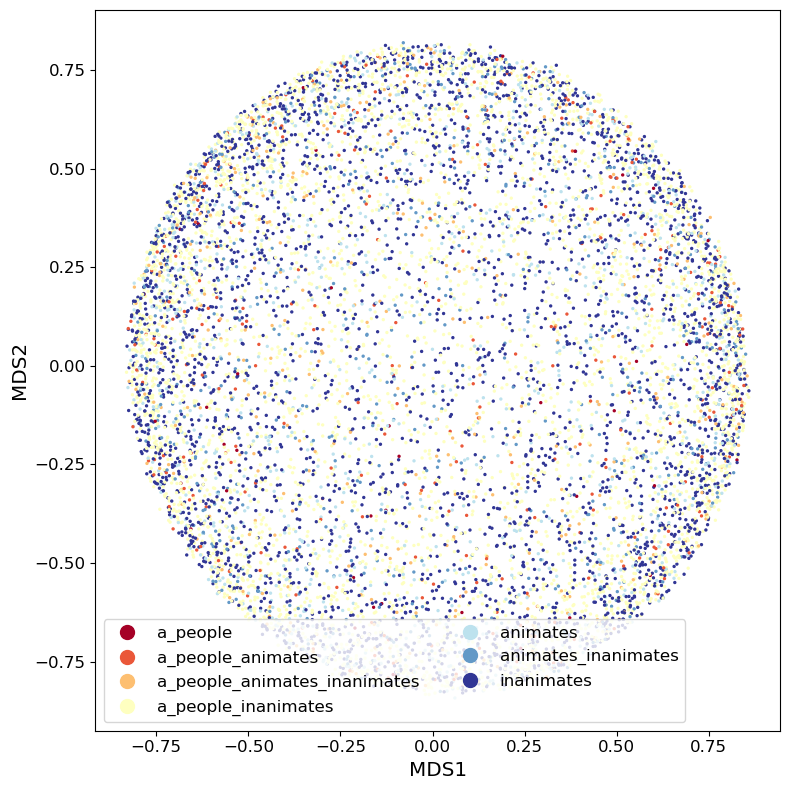

In [21]:
scprep.plot.scatter2d(
        mds_V1R,
        c=class_labels,
        figsize=(8, 8),
        cmap="RdYlBu",
        ticks=True,
        legend_loc='lower left',
        legend_ncol=2,
        label_prefix="MDS"
    )

In [22]:
mds_V2_path = os.path.join(mds_dir, 'subj01', 'subj01_V2_mds_train.npy')
mds_V2 = np.load(mds_V2_path)
mds_V2R_path = os.path.join(mds_dir, 'subj01', 'subj01_V2_MDS_rotated_VO-1_train.npy')
mds_V2R = np.load(mds_V2R_path)
mds_V2R

array([[-0.80014133,  0.16267702],
       [-0.618419  , -0.44510913],
       [-0.00412112, -0.34480724],
       ...,
       [-0.12589721, -0.5646151 ],
       [ 0.2735361 , -0.26749653],
       [ 0.03622986,  0.6374147 ]], dtype=float32)

/home/harveylab/miniconda3/envs/thesis/lib/python3.10/site-packages/scprep/plot/utils.py:104: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


<Axes: xlabel='MDS1', ylabel='MDS2'>

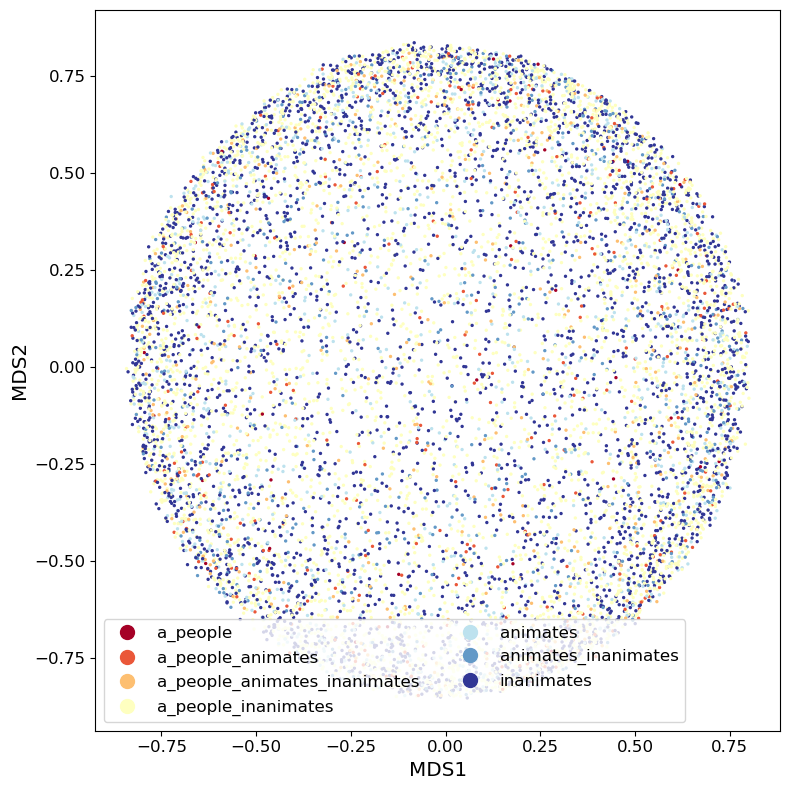

In [23]:
scprep.plot.scatter2d(
        mds_V2,
        c=class_labels,
        figsize=(8, 8),
        cmap="RdYlBu",
        ticks=True,
        legend_loc='lower left',
        legend_ncol=2,
        label_prefix="MDS"
    )

/home/harveylab/miniconda3/envs/thesis/lib/python3.10/site-packages/scprep/plot/utils.py:104: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


<Axes: xlabel='MDS1', ylabel='MDS2'>

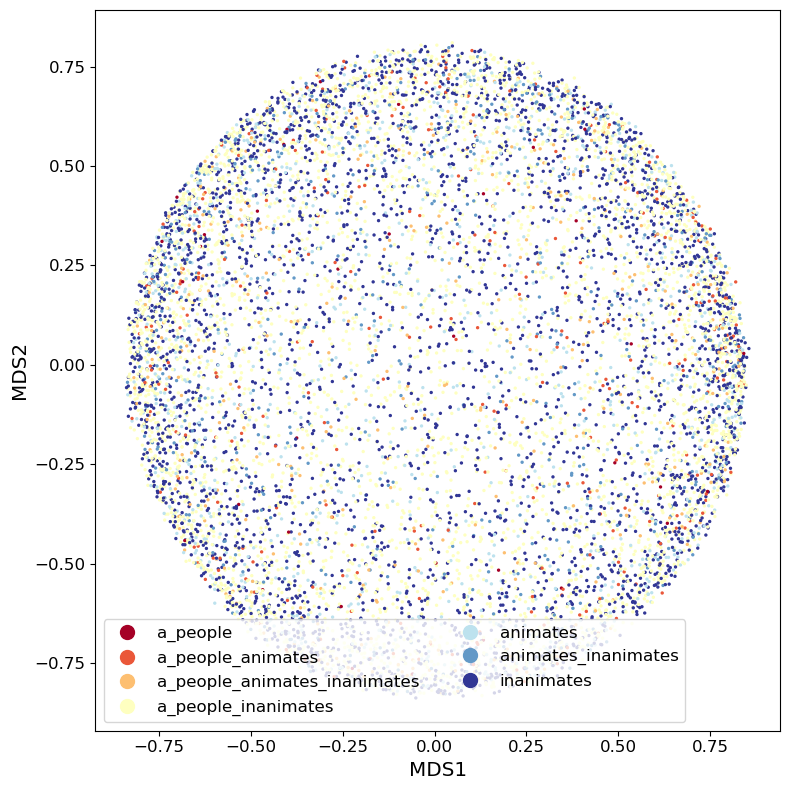

In [24]:
scprep.plot.scatter2d(
        mds_V2R,
        c=class_labels,
        figsize=(8, 8),
        cmap="RdYlBu",
        ticks=True,
        legend_loc='lower left',
        legend_ncol=2,
        label_prefix="MDS"
    )